In [1]:
import sys
import arrow
import numpy as np
from numpy.linalg import norm

class PMF(object):
    '''
    Probabilistic Matrix Factorization
    '''

    def __init__(self, n_feature, epsilon, lam, n_epoches, n_batches):
        self.n_feature = n_feature  # number of features
        self.epsilon   = epsilon    # epsilon for leanring rate
        self.lam       = lam        # lambda for L2 regularization

        self.n_epoches = n_epoches  # number of epoches
        self.n_batches = n_batches  # number of batches

        self.V = None # items feature matrix
        self.U = None # users feature matrix
        self.train_loss = []
        self.test_loss = []
        self.test_mse = []

    def loss(self, ratings):
        '''
        Loss Function for evaluating matrix U and V
        '''
        errors = [
            (float(r_ij) - np.dot(self.U[int(i)], self.V[int(j)].T))**2 + \
            self.lam * norm(self.U[int(i)]) + self.lam * norm(self.V[int(j)])
            for i, j, r_ij in ratings]
        return sum(errors)
    
    def squared_error(self, ratings):
        return sum([(float(r_ij) - np.dot(self.U[int(i)], self.V[int(j)].T))**2 for i, j, r_ij in ratings ]) 

    def sgd_update(self, ratings):
        '''
        Update matrix U and V by Stochastic Gradient Descent.
        '''
        for i, j, r_ij in ratings:
            i = int(i)
            j = int(j)
            r_ij_hat = np.dot(self.U[i], self.V[j].T)
            grad_U_i = (r_ij_hat - float(r_ij)) * self.V[j] + self.lam * self.U[i]
            grad_V_j = (r_ij_hat - float(r_ij)) * self.U[i] + self.lam * self.V[j]
            self.U[i] = self.U[i] - self.epsilon * grad_U_i
            self.V[j] = self.V[j] - self.epsilon * grad_V_j

    def fit(self, train_ratings, test_ratings):
        '''
        Fit PMF model with respect to the ratings. A rating is a triple (user,
        item, rating), in particular, user and item are integers to indicate
        unique ids respectively, and rating is a real value score that associates
        with corresponding user and item. For here, ratings is a numpy array
        with shape (n, 3).

        Params:
        - train_ratings: ratings entries for training purpose
        - test_ratings:  ratings entries for testing purpose
        '''
        # get number of training samples and testing samples
        n_trains = train_ratings.shape[0]
        n_tests  = test_ratings.shape[0]
        # get number of items and number of users
        n_users  = int(max(np.amax(train_ratings[:, 0]), np.amax(test_ratings[:, 0]))) + 1
        n_items  = int(max(np.amax(train_ratings[:, 1]), np.amax(test_ratings[:, 1]))) + 1
        # Initialization
        if self.V is None or self.U is None:
            self.e = 0
            self.U = 0.1 * np.random.randn(n_users, self.n_feature)
            self.V = 0.1 * np.random.randn(n_items, self.n_feature)
        # training iterations over epoches
        while self.e < self.n_epoches:
            self.e += 1
            # shuffle training samples
            shuffled_order = np.arange(n_trains)
            np.random.shuffle(shuffled_order)
            # training iterations over batches
            avg_train_loss = []
            avg_test_loss  = []
            batch_size     = int(n_trains / self.n_batches)
            for batch in range(self.n_batches):
                idx       = np.arange(batch_size * batch, batch_size * (batch + 1))
                batch_idx = np.mod(idx, n_trains).astype('int32')
                # training ratings selected in current batch
                batch_ratings = train_ratings[shuffled_order[batch_idx], :]
                # test ratings sample with the same size as the training batch
                sample_test_ratings = test_ratings[np.random.choice(n_tests, batch_size), :]
                # update U and V by sgd in a close-formed gradient
                self.sgd_update(batch_ratings)
                # loss for training and testing U, V and ratings
                train_loss = self.loss(batch_ratings)
                test_loss  = self.loss(sample_test_ratings)
                avg_train_loss.append(train_loss)
                avg_test_loss.append(test_loss)
                
            # training log ouput
            rmse = (self.squared_error(test_ratings) / float(len(test_ratings)))**0.5
            avg_train_loss = np.mean(avg_train_loss) / float(batch_size)
            avg_test_loss  = np.mean(avg_test_loss) / float(batch_size)
            self.train_loss.append(avg_train_loss)
            self.test_loss.append(avg_test_loss)
            self.test_mse.append(rmse)
            print('[%s] Epoch %d' % (arrow.now(), self.e), file=sys.stderr)
            print('[%s] Training loss:\t%f' % (arrow.now(), avg_train_loss), file=sys.stderr)
            print('[%s] Testing loss:\t%f' % (arrow.now(), avg_test_loss), file=sys.stderr)
            print('[%s] Testing MSE:\t%f' % (arrow.now(), rmse), file=sys.stderr)



In [2]:
import pandas as pd
import numpy as np


In [3]:
ratingsdf = pd.read_csv('Ratings.csv')
ratings = ratingsdf.to_numpy()
shuffled_order = np.arange(len(ratings))
np.random.shuffle(shuffled_order)
ratings        = ratings[shuffled_order]
# cross validation
train_ratings  = ratings[0:400000, :]
test_ratings   = ratings[400000:, :]
print('training:', train_ratings.shape)
print('testing:', test_ratings.shape)
pmf = PMF(n_feature=100, epsilon=0.1, lam=0.1, n_epoches=10, n_batches=1000)
pmf.fit(train_ratings, test_ratings)

training: (400000, 3)
testing: (168453, 3)


[2020-03-19T10:34:14.709833+08:00] Epoch 1
[2020-03-19T10:34:14.711069+08:00] Training loss:	6.780393
[2020-03-19T10:34:14.711834+08:00] Testing loss:	15.379416
[2020-03-19T10:34:14.713290+08:00] Testing MSE:	12.073487
[2020-03-19T10:35:25.775887+08:00] Epoch 2
[2020-03-19T10:35:25.777882+08:00] Training loss:	1.818375
[2020-03-19T10:35:25.780228+08:00] Testing loss:	12.285086
[2020-03-19T10:35:25.781882+08:00] Testing MSE:	11.538401
[2020-03-19T10:36:40.772324+08:00] Epoch 3
[2020-03-19T10:36:40.775316+08:00] Training loss:	0.779181
[2020-03-19T10:36:40.776089+08:00] Testing loss:	11.918559
[2020-03-19T10:36:40.781106+08:00] Testing MSE:	11.389271
[2020-03-19T10:37:50.953096+08:00] Epoch 4
[2020-03-19T10:37:50.954700+08:00] Training loss:	0.543854
[2020-03-19T10:37:50.955663+08:00] Testing loss:	11.797881
[2020-03-19T10:37:50.955663+08:00] Testing MSE:	11.321439
[2020-03-19T10:39:07.853188+08:00] Epoch 5
[2020-03-19T10:39:07.855006+08:00] Training loss:	0.496274
[2020-03-19T10:39:07.8

[6.729354528016873, 1.8082611907490977, 0.7689597407673103, 0.5401297620315872, 0.4943961919805513, 0.4815152163207784, 0.47595262520939763, 0.47260138777063504, 0.4699093500104911, 0.46788568989275575] [15.349498571388464, 12.17599957140731, 11.844380552343269, 11.700514457789566, 11.66930942465255, 11.580442196924352, 11.544197865707474, 11.53765454042004, 11.504669326633145, 11.455365849341392] [11.984511639642276, 11.439358607707467, 11.297403086995843, 11.22775551851176, 11.184261532449614, 11.139401752555917, 11.108293667630136, 11.07483079587502, 11.04586903170292, 11.019710121190576]


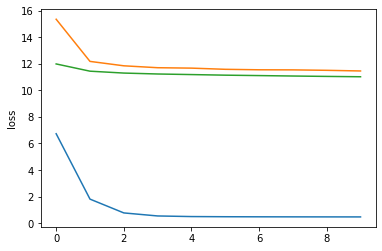

In [20]:
import matplotlib.pyplot as plt
print(pmf.train_loss, pmf.test_loss, pmf.test_mse)
plt.plot(pmf.train_loss)
plt.plot(pmf.test_loss)
plt.plot(pmf.test_mse)

plt.ylabel('loss')
plt.show()

In [45]:
# try Ratings_vip_moderateS.csv
ratingsdf = pd.read_csv('Ratings_vip_moderateS.csv')
ratings = ratingsdf.to_numpy()
shuffled_order = np.arange(len(ratings))
np.random.shuffle(shuffled_order)
ratings        = ratings[shuffled_order]
# cross validation
train_ratings  = ratings[0:300000, :]
test_ratings   = ratings[300000:, :]
print('training:', train_ratings.shape)
print('testing:', test_ratings.shape)
pmf = PMF(n_feature=100, epsilon=0.1, lam=0.1, n_epoches=10, n_batches=1000)
pmf.fit(train_ratings, test_ratings)

training: (300000, 3)
testing: (93062, 3)


[2020-03-05T16:12:51.679943+08:00] Epoch 1
[2020-03-05T16:12:51.679943+08:00] Training loss:	5.140001
[2020-03-05T16:12:51.679943+08:00] Testing loss:	12.465479
[2020-03-05T16:12:51.679943+08:00] Testing MSE:	7.749849
[2020-03-05T16:13:13.294310+08:00] Epoch 2
[2020-03-05T16:13:13.295308+08:00] Training loss:	1.114807
[2020-03-05T16:13:13.295308+08:00] Testing loss:	7.734725
[2020-03-05T16:13:13.296305+08:00] Testing MSE:	6.737732
[2020-03-05T16:13:40.173455+08:00] Epoch 3
[2020-03-05T16:13:40.174453+08:00] Training loss:	0.577669
[2020-03-05T16:13:40.174453+08:00] Testing loss:	7.141840
[2020-03-05T16:13:40.174453+08:00] Testing MSE:	6.593993
[2020-03-05T16:13:57.612875+08:00] Epoch 4
[2020-03-05T16:13:57.613872+08:00] Training loss:	0.492684
[2020-03-05T16:13:57.613872+08:00] Testing loss:	6.996447
[2020-03-05T16:13:57.613872+08:00] Testing MSE:	6.467844
[2020-03-05T16:14:16.152315+08:00] Epoch 5
[2020-03-05T16:14:16.153311+08:00] Training loss:	0.474507
[2020-03-05T16:14:16.154308+0

[5.14000117350638, 1.1148067295316346, 0.5776694131337967, 0.49268351729029886, 0.47450742625139697, 0.4684502329072774, 0.4648560703891457, 0.4622284601016978, 0.4600659344779705, 0.45816569538668206] [12.46547892520831, 7.734725218533011, 7.141840131439326, 6.996447352024931, 6.889808571048644, 6.799660073071595, 6.781357762681441, 6.705500155903765, 6.643206293954012, 6.589354966447117] [7.749849454138211, 6.737731777224344, 6.593993495914206, 6.467844227016015, 6.39926037078911, 6.332338832317441, 6.2750151352991095, 6.219112482134953, 6.16634790254793, 6.114382325464348]


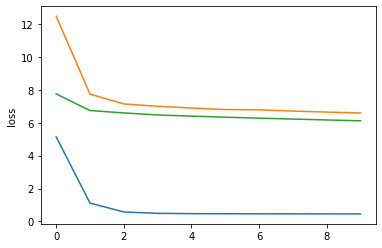

In [47]:
import matplotlib.pyplot as plt
print(pmf.train_loss, pmf.test_loss, pmf.test_mse)
plt.plot(pmf.train_loss)
plt.plot(pmf.test_loss)
plt.plot(pmf.test_mse)

plt.ylabel('loss')
plt.show()

training: (300000, 3)
testing: (93062, 3)


[2020-03-19T10:57:09.472518+08:00] Epoch 1
[2020-03-19T10:57:09.472518+08:00] Training loss:	4.139345
[2020-03-19T10:57:09.472518+08:00] Testing loss:	9.787242
[2020-03-19T10:57:09.472518+08:00] Testing MSE:	6.276367
[2020-03-19T10:57:32.583737+08:00] Epoch 2
[2020-03-19T10:57:32.583737+08:00] Training loss:	1.024951
[2020-03-19T10:57:32.583737+08:00] Testing loss:	6.265730
[2020-03-19T10:57:32.583737+08:00] Testing MSE:	5.416068
[2020-03-19T10:57:55.032499+08:00] Epoch 3
[2020-03-19T10:57:55.034501+08:00] Training loss:	0.537299
[2020-03-19T10:57:55.034501+08:00] Testing loss:	5.784373
[2020-03-19T10:57:55.035498+08:00] Testing MSE:	5.310723
[2020-03-19T10:58:20.427500+08:00] Epoch 4
[2020-03-19T10:58:20.428497+08:00] Training loss:	0.464151
[2020-03-19T10:58:20.428497+08:00] Testing loss:	5.710638
[2020-03-19T10:58:20.428497+08:00] Testing MSE:	5.222860
[2020-03-19T10:59:01.614921+08:00] Epoch 5
[2020-03-19T10:59:01.619919+08:00] Training loss:	0.449652
[2020-03-19T10:59:01.619919+08

[4.139345418514663, 1.0249506485899014, 0.5372993960494835, 0.4641506765857102, 0.4496524975305897, 0.4446979292979522, 0.44149213942771437, 0.4390876910403811, 0.4370952792360106, 0.43542165449701664] [9.787241760370195, 6.265729530849655, 5.784373237492563, 5.710638171889968, 5.620884698552332, 5.589793129784601, 5.511563322383129, 5.48773314785975, 5.473310108357879, 5.401639987425319] [6.276366913836662, 5.416067917991074, 5.310722675984075, 5.222860442198129, 5.172820734538798, 5.128493921256843, 5.085265130421476, 5.0524909236275635, 5.017114169330066, 4.982878030998066]


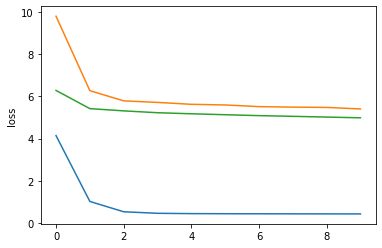

In [5]:
# try Ratings_vip_sa.csv
ratingsdf = pd.read_csv('Ratings_vip_sa.csv')
ratings = ratingsdf.to_numpy()
shuffled_order = np.arange(len(ratings))
np.random.shuffle(shuffled_order)
ratings        = ratings[shuffled_order]
# cross validation
train_ratings  = ratings[0:300000, :]
test_ratings   = ratings[300000:, :]
print('training:', train_ratings.shape)
print('testing:', test_ratings.shape)
pmf = PMF(n_feature=100, epsilon=0.1, lam=0.1, n_epoches=10, n_batches=1000)
pmf.fit(train_ratings, test_ratings)
import matplotlib.pyplot as plt
print(pmf.train_loss, pmf.test_loss, pmf.test_mse)
plt.plot(pmf.train_loss)
plt.plot(pmf.test_loss)
plt.plot(pmf.test_mse)

plt.ylabel('loss')
plt.show()